In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Input, BatchNormalization, Add, AveragePooling2D, MaxPooling2D, ZeroPadding2D, ReLU, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
# !unzip -qq cell_images.zip

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, # scale pixel to (0, 1) value
                            validation_split=0.2) # set validation split

In [ ]:
data_dir = '/content/cell_images'

In [ ]:
image_size = (224, 224)
batch_size = 128
epochs = 10

In [ ]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

Found 22048 images belonging to 2 classes.


In [ ]:
validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 5510 images belonging to 2 classes.


In [ ]:
image, label = next(train_generator)

In [ ]:
image.shape

(128, 224, 224, 3)

In [ ]:
train_generator.class_indices # Label map 

{'Parasitized': 0, 'Uninfected': 1}

In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut]) # residual connection
    X = ReLU()(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, stride=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, 
               kernel_size=(1, 1), 
               strides=(stride, stride), 
               padding='valid', 
               name=conv_name_base + '2a', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F2, 
               kernel_size=(f, f), 
               strides=(1, 1), 
               padding='same', 
               name=conv_name_base + '2b', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = ReLU()(X)

    X = Conv2D(filters=F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, 
                        kernel_size=(1, 1), 
                        strides=(stride, stride), 
                        padding='valid', name=conv_name_base + '1', 
                        kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut]) # residual connection
    X = ReLU()(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3), output_shape=1):

    inputs = Input(input_shape, name='input')

    X = ZeroPadding2D((3, 3))(inputs)

    X = Conv2D(filters=64, 
               kernel_size=(7, 7), 
               strides=(2, 2), 
               name='conv1', 
               kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = ReLU()(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', stride=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', stride=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', stride=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', stride=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1', kernel_initializer='glorot_uniform')(X)
    X = Dense(128, activation='relu', name='fc2', kernel_initializer='glorot_uniform')(X)
    assert output_shape>=1
    if output_shape==1:
        outputs = Dense(output_shape, activation='sigmoid')(X) # Binary class classification
    else:
        outputs = Dense(output_shape, activation='softmax')(X)
    model = Model(inputs=inputs, outputs=outputs, name='ResNet50') # Multi class classification

    return model

In [ ]:
model = ResNet50(input_shape=(*image_size, 3), output_shape=1)

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [ ]:
# If the val loss did not decrease in 3 times, model will stop training and restore best weights
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [ ]:
model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[early_stopping])

Epoch 1/10
173/173 [==============================] - 270s 1s/step - loss: 1.4010 - accuracy: 0.5868 - val_loss: 0.6705 - val_accuracy: 0.5574
Epoch 2/10
173/173 [==============================] - 252s 1s/step - loss: 0.4413 - accuracy: 0.8031 - val_loss: 0.6328 - val_accuracy: 0.7000
Epoch 3/10
173/173 [==============================] - 253s 1s/step - loss: 0.1560 - accuracy: 0.9522 - val_loss: 0.1538 - val_accuracy: 0.9497
Epoch 4/10
173/173 [==============================] - 252s 1s/step - loss: 0.1310 - accuracy: 0.9575 - val_loss: 0.1848 - val_accuracy: 0.9454
Epoch 5/10
173/173 [==============================] - 253s 1s/step - loss: 0.1169 - accuracy: 0.9618 - val_loss: 0.1668 - val_accuracy: 0.9441
Epoch 6/10
173/173 [==============================] - 253s 1s/step - loss: 0.1123 - accuracy: 0.9629 - val_loss: 0.1729 - val_accuracy: 0.9437


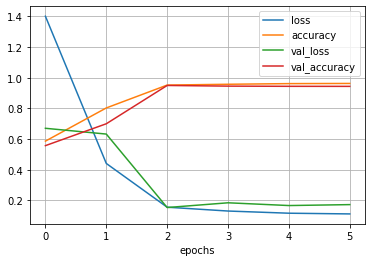

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.xlabel("epochs")
plt.show()

In [ ]:
images, labels = next(validation_generator)

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [ ]:
parasited_sample="/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"
unifected_sample="/content/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_144.png"

In [ ]:
image_parasited = decode_and_resize(parasited_sample)
image_unifected = decode_and_resize(unifected_sample)

In [ ]:
image_parasited.shape

TensorShape([224, 224, 3])

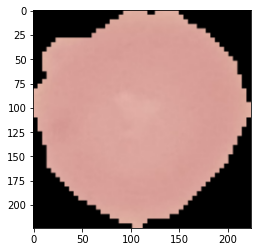

Model predict: 0


In [ ]:
pred = model.predict(tf.expand_dims(image_parasited, 0))
if pred >= 0.5:
    pred = 1
else:
    pred = 0

plt.imshow(image_unifected.numpy().clip(0, 255).astype(np.uint8))
plt.show()
print('Model predict:', pred)

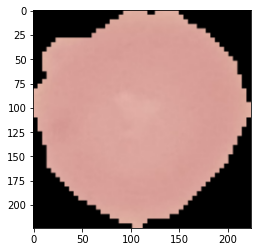

Model predict: 0


In [ ]:
pred = model.predict(tf.expand_dims(image_unifected, 0))
if pred >= 0.5:
    pred = 1
else:
    pred = 0

plt.imshow(image_unifected.numpy().clip(0, 255).astype(np.uint8))
plt.show()
print('Model predict:', pred)

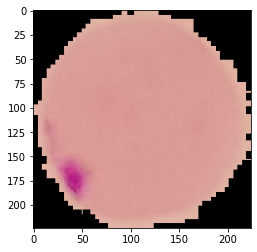

Model predict:  0
Ground truth:  0.0



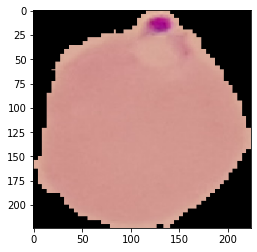

Model predict:  0
Ground truth:  0.0



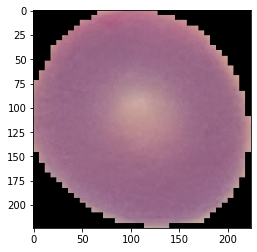

Model predict:  1
Ground truth:  1.0



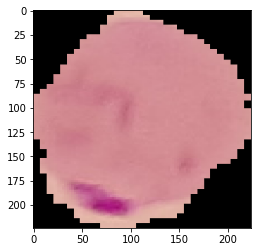

Model predict:  0
Ground truth:  0.0



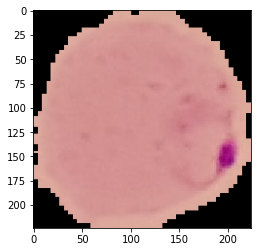

Model predict:  0
Ground truth:  0.0



In [ ]:
for i in range(5):
    # images[i,:] take image i-th from validation batch, shape 224, 224, 3
    # Use expand_dims to convert it to (1, 224, 224, 3) because model only predict by (batch, shape)
    image = images[i,:]
    pred = model.predict(tf.expand_dims(image, 0))
    if pred >= 0.5:
        pred = 1
    else:
        pred = 0
    plt.imshow(image)
    plt.show()
    print('Model predict: ', pred)
    print('Ground truth: ', labels[i])
    print()

In [ ]:
model.save('Malaria_resnet50')

INFO:tensorflow:Assets written to: Malaria_resnet50/assets


In [ ]:
!zip -r Malaria_resnet50.zip . content/Malaria_resnet50/

	zip warning: name not matched: content/Malaria_resnet50/
  adding: keras_metadata.pb (deflated 95%)
  adding: variables/ (stored 0%)
  adding: variables/variables.data-00000-of-00001 (deflated 13%)
  adding: variables/variables.index (deflated 81%)
  adding: assets/ (stored 0%)
  adding: saved_model.pb (deflated 92%)


In [ ]:
import os

In [ ]:
def convert_bytes(size):
    """ Convert bytes to KB, or MB or GB"""
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0

In [ ]:
convert_bytes(os.path.getsize('Malaria_resnet50.zip'))

'317.8 MB'